In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
!pip install -q tfds-nightly matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 35.1 MB/s eta 0:00:00


In [ ]:
dataset, info = tfds.load('smallnorb', with_info=True, as_supervised=True) # Dataset take from https://www.tensorflow.org/datasets/catalog/smallnorb . 5 categories
# as_supervised=True secures the model.fit receives tuples
# with_info=True to get metadata
# is loading like a dict, no tuples dataset['train'] would return {'image': <Tensor>, 'label': <int>}

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/smallnorb/incomplete.NRBZTY_2.0.0/smallnorb-train.tfrecord*...:   0%|     …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/smallnorb/incomplete.NRBZTY_2.0.0/smallnorb-test.tfrecord*...:   0%|      …

Dataset smallnorb downloaded and prepared to /root/tensorflow_datasets/smallnorb/2.0.0. Subsequent calls will reuse this data.


<Figure size 800x800 with 0 Axes>

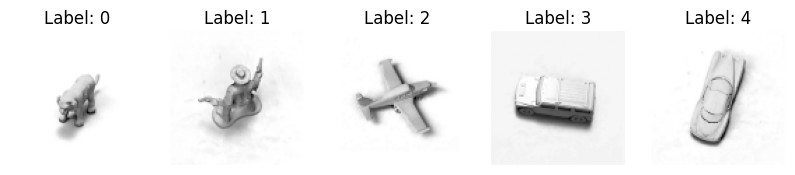

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualize some examples from the train data
# select the test data
test_data = dataset['test']

# Create 2x2 subplot grid
plt.figure(figsize=(8, 8))

# Plot 5 examples, one of each category

selected = {}
for image, label in test_data:
    label_val = int(label.numpy())
    if label_val not in selected:
        selected[label_val] = image
    # Stop when we have all 5 labels
    if len(selected) == 5:
        break

# Plot them
plt.figure(figsize=(10, 2))
for i, (label_val, image) in enumerate(sorted(selected.items())):
    plt.subplot(1, 5, i + 1)
    plt.imshow(image.numpy().squeeze(), cmap='gray')
    plt.title(f'Label: {label_val}')
    plt.axis('off')

plt.show()

plt.tight_layout()
plt.show()

In [ ]:
# General info
print("Total examples:", info.splits['train'].num_examples + info.splits['test'].num_examples,
      "Training set:", info.splits['train'].num_examples,
      "Test set:", info.splits['test'].num_examples)

print(image.dtype, tf.reduce_max(image), tf.reduce_min(image))# Normalizar soon

test_data = dataset['test']

Total examples: 48600 Training set: 24300 Test set: 24300
<dtype: 'uint8'> tf.Tensor(228, shape=(), dtype=uint8) tf.Tensor(81, shape=(), dtype=uint8)


In [ ]:
# Extract the tuples (image, labels) for the train and test sets

for example in test_data.take(1):
    print(example) # it yields a tuple, an image tensor normalized and a label is a scalar int 64

(<tf.Tensor: shape=(96, 96, 1), dtype=uint8, numpy=
array([[[206],
        [206],
        [206],
        ...,
        [206],
        [206],
        [206]],

       [[206],
        [206],
        [206],
        ...,
        [206],
        [206],
        [206]],

       [[206],
        [206],
        [206],
        ...,
        [206],
        [206],
        [206]],

       ...,

       [[205],
        [205],
        [205],
        ...,
        [205],
        [206],
        [206]],

       [[205],
        [205],
        [205],
        ...,
        [205],
        [206],
        [206]],

       [[206],
        [206],
        [206],
        ...,
        [206],
        [206],
        [206]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=3>)


In [ ]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Only normalize test_data
test_data = test_data.map(normalize)

for example in test_data.take(1):
    print(example)

(<tf.Tensor: shape=(96, 96, 1), dtype=float32, numpy=
array([[[0.80784315],
        [0.80784315],
        [0.80784315],
        ...,
        [0.80784315],
        [0.80784315],
        [0.80784315]],

       [[0.80784315],
        [0.80784315],
        [0.80784315],
        ...,
        [0.80784315],
        [0.80784315],
        [0.80784315]],

       [[0.80784315],
        [0.80784315],
        [0.80784315],
        ...,
        [0.80784315],
        [0.80784315],
        [0.80784315]],

       ...,

       [[0.8039216 ],
        [0.8039216 ],
        [0.8039216 ],
        ...,
        [0.8039216 ],
        [0.80784315],
        [0.80784315]],

       [[0.8039216 ],
        [0.8039216 ],
        [0.8039216 ],
        ...,
        [0.8039216 ],
        [0.80784315],
        [0.80784315]],

       [[0.80784315],
        [0.80784315],
        [0.80784315],
        ...,
        [0.80784315],
        [0.80784315],
        [0.80784315]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int64,

In [ ]:
# Use only the test set and separate it 80% train set (x_train), 20% test set (x_test)
split_size = int(24300 * 0.8)  # 19440
x_train = test_data.take(split_size)
x_test = test_data.skip(split_size)# skip function, it means you’re ignoring a certain number of elements from the beginning of the dataset

print( "Final examples in the train set:", len(x_train),
      "final examples in the test set:", len(x_test))

Final examples in the train set: 19440 final examples in the test set: 4860


In [ ]:
for _, label in x_train.take(1):
    print(label.shape)  # should be () not (5,)

()


In [ ]:
# Create the model

# Set random seed
tf.random.set_seed(29)

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(96, 96, 1)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3), # 30% of neurons dropped during training
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(5, activation="softmax")
])

# Compile the model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                 optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                 metrics=["accuracy"])

# Fit the mode, feed it with the tuples and set up the batch
norm_history = model.fit(x_train.batch(64),
                         epochs=50,
                         validation_data= x_test.batch(64))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


304/304 ━━━━━━━━━━━━━━━━━━━━ 36s 114ms/step - accuracy: 0.2244 - loss: 1.6539 - val_accuracy: 0.4434 - val_loss: 1.5410
Epoch 2/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.2772 - loss: 1.5394 - val_accuracy: 0.4574 - val_loss: 1.3959
Epoch 3/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.3254 - loss: 1.4114 - val_accuracy: 0.4751 - val_loss: 1.2479
Epoch 4/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.3545 - loss: 1.3266 - val_accuracy: 0.5391 - val_loss: 1.1454
Epoch 5/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.3785 - loss: 1.2785 - val_accuracy: 0.5549 - val_loss: 1.1233
Epoch 6/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.3919 - loss: 1.2462 - val_accuracy: 0.5794 - val_loss: 1.0897
Epoch 7/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.4038 - loss: 1.2207 - val_accuracy: 0.5809 - val_loss: 1.0704
Epoch 8/50
304/304 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.4126 - loss: 1.2088 - val_accuracy: 0

In [ ]:
# Evaluate the model on the test
loss_train, accur_train = model.evaluate(x_train.batch(64).prefetch(tf.data.AUTOTUNE))
loss_test, accur_test = model.evaluate(x_test.batch(64).prefetch(tf.data.AUTOTUNE))#  creating a buffer and using to prepare the next batch of data while
# the GPU is still busy with the current

print(f'Final accuracy training:{100*accur_train:.2f}%, final loss training {loss_train}')
print(f'Final accuracy test:{100*accur_test:.2f}%, final loss test {loss_test}')

304/304 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7117 - loss: 0.7625
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7093 - loss: 0.7667
Final accuracy training:71.17%, final loss training 0.7616284489631653
Final accuracy test:70.08%, final loss test 0.7736933827400208


   accuracy      loss  val_accuracy  val_loss
0  0.240432  1.603966      0.443416  1.540964
1  0.288169  1.508420      0.457407  1.395892
2  0.328549  1.387011      0.475103  1.247865
3  0.359465  1.312532      0.539095  1.145403
4  0.383642  1.269821      0.554938  1.123342


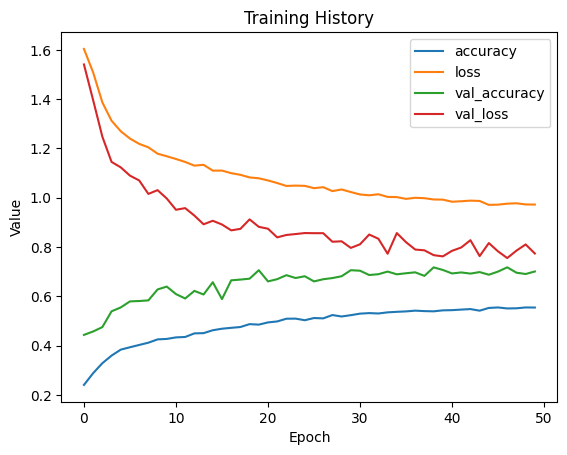

In [ ]:
import pandas as pd
history_df = pd.DataFrame(norm_history.history)# this is the df to be plotted
print(history_df.head(5))
history_df.plot(title="Training History")  # This will include accuracy, loss, val_accuracy, val_loss
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()

In [ ]:
# Make predictions with the most recent model
y_probs = model.predict(x_test.batch(32))

# View the first 5 predictions
y_probs[:5]

152/152 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


array([[1.4606766e-01, 2.4207935e-02, 5.2395403e-01, 3.7813585e-02,
        2.6795673e-01],
       [3.8323224e-01, 5.1168877e-01, 1.0506588e-01, 1.2268312e-08,
        1.3072181e-05],
       [4.9538244e-03, 3.6125540e-04, 2.0249189e-01, 2.2080423e-01,
        5.7138878e-01],
       [5.0246549e-01, 1.9186155e-01, 3.0062118e-01, 6.9909336e-05,
        4.9820235e-03],
       [4.9976209e-01, 1.8972465e-01, 3.0493146e-01, 8.1613674e-05,
        5.5001150e-03]], dtype=float32)

In [ ]:
y_preds = y_probs.argmax(axis=1)
y_preds[:10]

array([2, 1, 4, 0, 0, 2, 0, 1, 0, 0])

In [ ]:
# get the true labels from the tuples of the x_test

y_true = [label.numpy() for _, label in x_test]

In [ ]:
# Check out the non-prettified confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true=y_true,
                 y_pred=y_preds)

array([[877,  45,  73,   0,  22],
       [375, 612,  26,   0,   1],
       [205,   2, 692,   0,  55],
       [  0,   0,  11, 460, 455],
       [  7,   0, 172,   5, 765]])

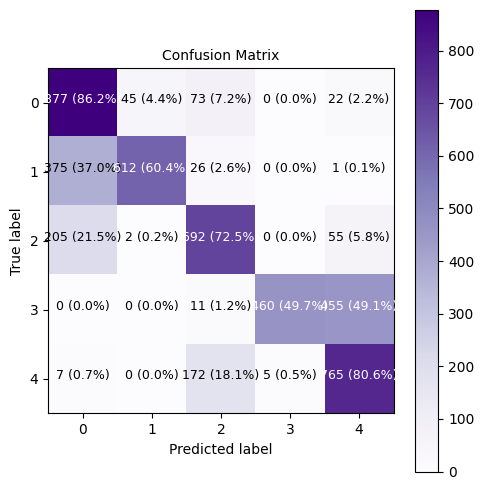

'Function adapted/taken from:1.https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html,\n  2. https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb\n  3. Tensorflow and DL with Python https://www.youtube.com/watch?v=tpCFfeUEGs8&ab_channel=DanielBourke '

In [ ]:
# grafica de un img random con traduccion.
# Plot confusion matrix function
import itertools
import numpy as np

figsize = (5, 5)

# Create the confusion matrix
cm = confusion_matrix(y_true, tf.round(y_preds))
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it.
n_classes = cm.shape[0]

# Let's prettify it
fig, ax = plt.subplots(figsize=figsize)
# Create a matrix plot
cax = ax.matshow(cm, cmap=plt.cm.Purples)
# ax.matshow() creates a matrix plot of the confusion matrix cm
fig.colorbar(cax) # Adds a color bar to the plot

# Create classes
classes = False

if classes:
  labels = classes
else:
  labels = np.arange(cm.shape[0])

# Label the axes
ax.set(title="Confusion Matrix",
       xlabel="Predicted label",
       ylabel="True label",
       xticks=np.arange(n_classes),
       yticks=np.arange(n_classes),
       xticklabels=labels,
       yticklabels=labels)

# Set x-axis labels to bottom
ax.xaxis.set_label_position("bottom")
ax.xaxis.tick_bottom() # move the x-axis ticks to the bottom of the plot

# Adjust label size
ax.xaxis.label.set_size(10)
ax.yaxis.label.set_size(10)
ax.title.set_size(10)

# Set threshold for different colors
threshold = (cm.max() + cm.min()) / 2.

# Plot the text on each cell
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(
        j, i,
        f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
        horizontalalignment="center",
        color="white" if cm[i, j] > threshold else "black",
        size=9
    )

plt.tight_layout()
plt.show() #
plt.close(fig)  # frees it so the next cell starts fresh
"""Function adapted/taken from:1.https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html,
  2. https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  3. Tensorflow and DL with Python https://www.youtube.com/watch?v=tpCFfeUEGs8&ab_channel=DanielBourke """

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[1.82170545e-09 1.12942974e-10 4.29773150e-04 9.62761045e-01
  3.68091464e-02]]


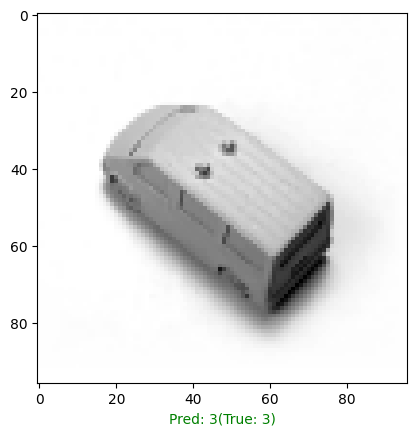

In [ ]:
def plot_random_image_from_dataset(model, dataset, classes):
    # Pick a random example
    dataset = dataset.shuffle(1000)  # shuffle to get randomness
    image, true_label = next(iter(dataset.take(1))) #  creates an iterator over this dataset.retrieves the next item from this iterator, which is a single batch of data.

    # Predict
    pred_probs = model.predict(image[None, ...])  # image[None, ...] changes the shape to (96, 96, 1). None creates a new axis of size 1.
    # image[None].shape is (1, 96, 96, 1)
    # shorthand for writing out all the slices explicitly, i.e. image[None, :, :, :]
    # image[None, ...] → (1, 96, 96, 1)
    print(pred_probs)

    pred_label = classes[pred_probs.argmax()]

    plt.imshow(image.numpy().squeeze(), cmap='gray')

    color = "green" if pred_label == classes[true_label.numpy()] else "red"
    plt.xlabel(f"Pred: {pred_label}"
              f"(True: {classes[true_label.numpy()]})", color=color)
    plt.show()
    plt.close()

# Call it
plot_random_image_from_dataset(model, test_data, classes=[0, 1, 2, 3, 4])